# 04 Threshold selection

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_auc_score, precision_recall_curve, precision_score, recall_score

In [4]:
data = "https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-03-churn-prediction/WA_Fn-UseC_-Telco-Customer-Churn.csv"

In [5]:
df = pd.read_csv(data)

df.columns = df.columns.str.lower().str.replace(' ', '_')

categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)

for c in categorical_columns:
    df[c] = df[c].str.lower().str.replace(' ', '_')

df.totalcharges = pd.to_numeric(df.totalcharges, errors='coerce')
df.totalcharges = df.totalcharges.fillna(0)

df.churn = (df.churn == 'yes').astype(int)

df['tenure'] = df.tenure.astype(float)

In [6]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.churn.values
y_val = df_val.churn.values
y_test = df_test.churn.values

del df_train['churn']
del df_val['churn']
del df_test['churn']

In [7]:
numerical = ['tenure', 'monthlycharges', 'totalcharges']

categorical = [
    'gender',
    'seniorcitizen',
    'partner',
    'dependents',
    'phoneservice',
    'multiplelines',
    'internetservice',
    'onlinesecurity',
    'onlinebackup',
    'deviceprotection',
    'techsupport',
    'streamingtv',
    'streamingmovies',
    'contract',
    'paperlessbilling',
    'paymentmethod',
]

In [8]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[categorical + numerical].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

In [9]:
def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [30]:
thresholds = np.linspace(0, 1, 101)

dv, model = train(df_train, y_train)
y_pred = predict(df_val, dv, model)

for th in thresholds:
    y_pred_bin = (y_pred >= th).astype(int)

    f1 = f1_score(y_val, y_pred_bin)
    auc = roc_auc_score(y_val, y_pred)
    precision, recall, _ = precision_recall_curve(y_val, y_pred_bin)
    #print(f"Threshold: {th:.2f}, F1: {f1:.5f}, AUC: {auc:.5f}")
    #print(f"Precision: {precision[1]:.5f}, Recall: {recall[1]:.5f}")
    #break


Try adding StandardScaler

In [31]:
def train_sc(dfx_train, y_train, C=1.0):
    #df_train.loc[:, numerical] = df_train[numerical].astype(float)
    df_train = dfx_train.copy()
    # for numerical columns, apply StandardScaler
    scaler = StandardScaler()
    scaler.fit(df_train[numerical])
    df_train.loc[:, numerical] = scaler.transform(df_train[numerical])

    dicts = df_train[categorical + numerical].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model, scaler

In [24]:
def predict_sc(dfx, dv, model, scaler):
    df = dfx.copy()
    #df.loc[:, numerical] = df[numerical].astype(float)
    df.loc[:, numerical] = scaler.transform(df[numerical])
    dicts = df[categorical + numerical].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [33]:
thresholds = np.linspace(0, 1, 101)

dv, model, scaler = train_sc(df_train, y_train)
y_pred_sc = predict_sc(df_val, dv, model, scaler)

precisions, recalls, f1_scores = [], [], []

for th in thresholds:
    y_pred_sc_bin = (y_pred_sc >= th).astype(int)

    f1 = f1_score(y_val, y_pred_sc_bin)
    auc = roc_auc_score(y_val, y_pred_sc)
    precision, recall, _ = precision_recall_curve(y_val, y_pred_sc_bin)
    #print(f"Threshold: {th:.2f}, F1: {f1:.5f}, AUC: {auc:.5f}")
    #print(f"Precision: {precision[1]:.5f}, Recall: {recall[1]:.5f}")

    precisions.append(precision[1])
    recalls.append(recall[1])
    f1_scores.append(f1)

    #break


Best threshold = 0.27, F1 = 0.640
Precision = 0.531, Recall = 0.806, F1 = 0.640


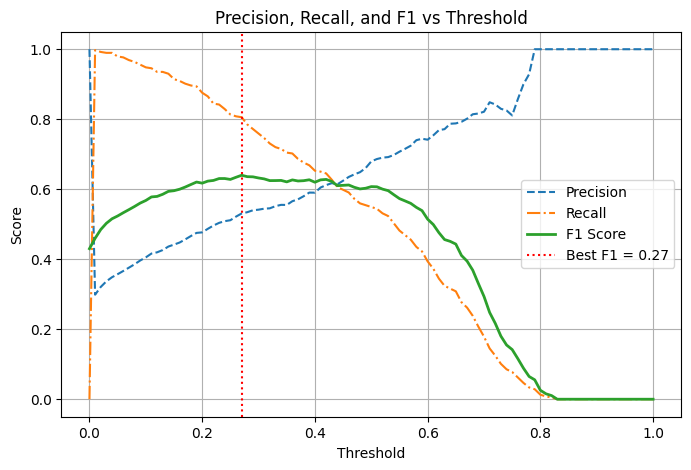

In [40]:
# Find best F1 threshold
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
best_f1 = f1_scores[best_idx]

print(f"Best threshold = {best_threshold:.2f}, F1 = {best_f1:.3f}")
print(f"Precision = {precisions[best_idx]:.3f}, Recall = {recalls[best_idx]:.3f}, F1 = {f1_scores[best_idx]:.3f}")

# Plot
plt.figure(figsize=(8, 5))
plt.plot(thresholds, precisions, label='Precision', linestyle='--')
plt.plot(thresholds, recalls, label='Recall', linestyle='-.')
plt.plot(thresholds, f1_scores, label='F1 Score', linewidth=2)

plt.axvline(best_threshold, color='red', linestyle=':', label=f'Best F1 = {best_threshold:.2f}')
plt.title('Precision, Recall, and F1 vs Threshold')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.show()


In [38]:
# find the threshold where precision and recall intersect, and get f1 score
for th in thresholds:
    y_pred_sc_bin = (y_pred_sc >= th).astype(int)

    precision, recall, _ = precision_recall_curve(y_val, y_pred_sc_bin)
    if np.isclose(precision[1], recall[1], atol=0.01):
        f1 = f1_score(y_val, y_pred_sc_bin)
        print(f"Precision and Recall intersect at threshold = {th:.2f}, Precision = {precision[1]:.3f}, Recall = {recall[1]:.3f}, F1 = {f1:.3f}")
        break


Precision and Recall intersect at threshold = 0.43, Precision = 0.617, Recall = 0.627, F1 = 0.622


At intersection between precision and recall:
* Threshold 0.43
* Precision 0.617
* Recall 0.627
* F1 0.622


At max F1 score:
* Threshold 0.27
* Precision 0.531
* Recall 0.806
* F1 0.64


